Let's train an autoencoder on slices of a cube. We'll have a set of 3D Gaussian blobs as the training data.

In [ ]:
import matplotlib.pyplot as plt
import numpy
import scipy.stats
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

In [2]:
torch.cuda.get_device_name(torch.cuda.current_device())

'GeForce GTX 1080'

## Making the dataset

$16 \times 32 \times 32$ Gaussian blobs embedded in a unit cube.

In [3]:
def make_blob():
    dist = scipy.stats.multivariate_normal(mean=numpy.random.uniform(size=(3,)),
                                           cov=numpy.random.uniform(0.1, 0.2))
    coords = numpy.mgrid[0:1:1/16, 0:1:1/32, 0:1:1/32].reshape((3, -1)).T
    return dist.pdf(coords).reshape((16, 32, 32))

In [4]:
data = numpy.array([make_blob() for i in range(2000)])

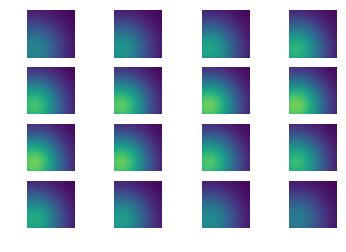

In [5]:
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(data[100][i], vmin=0, vmax=1)
    plt.axis('off')

In [7]:
data = torch.from_numpy(data).float()

In [8]:
data -= data.min()
data /= data.max()

## Autoencoder

Now we'll make an autoencoder that takes $32 \times 32$ images, transforms them to a 50-dimensional space, and then transforms them back.

In [6]:
# https://github.com/sksq96/pytorch-vae/

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def __init__(self, size=2304):
        super().__init__()
        self.size = size
    def forward(self, input):
        return input.view(input.size(0), self.size, 1, 1)

class VAE(nn.Module):
    def __init__(self, image_channels=3, z_dim=32):
        super(VAE, self).__init__()
        h_dim = 2304
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten(),
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
        
    def representation(self, x):
        return self.bottleneck(self.encoder(x))[0]

    def forward(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        z = self.fc3(z)
        return self.decoder(z), mu, logvar

    @staticmethod
    def loss(recon_x, x, mu, logvar):
        BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
        KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

        return BCE + KLD, BCE, KLD

In [13]:
vae = VAE(image_channels=16, z_dim=50).float()

In [14]:
optimiser = torch.optim.Adam(vae.parameters(), lr=1e-3)

/home/alg010/miniconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/50] Loss: 13155437.000 13155435.000 1.663


/home/alg010/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # Remove the CWD from sys.path while we load stuff.


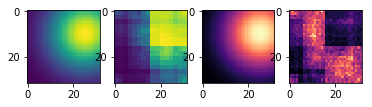

Epoch[2/50] Loss: 13046944.000 13046942.000 1.804


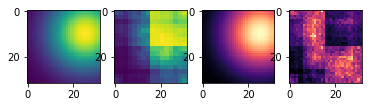

Epoch[3/50] Loss: 12905519.000 12905517.000 1.909


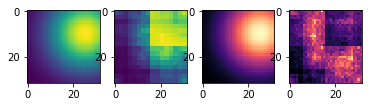

Epoch[4/50] Loss: 12795065.000 12795063.000 1.978


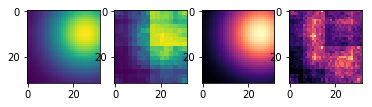

Epoch[5/50] Loss: 12711286.000 12711284.000 2.004


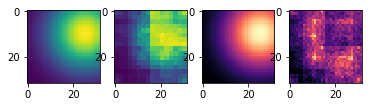

Epoch[6/50] Loss: 12617126.000 12617124.000 1.996


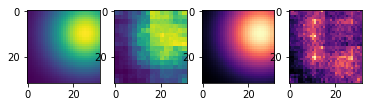

Epoch[7/50] Loss: 12557656.000 12557654.000 1.971


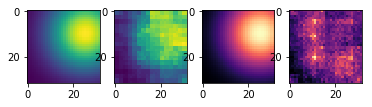

Epoch[8/50] Loss: 12481807.000 12481805.000 1.941


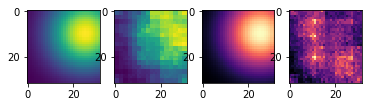

Epoch[9/50] Loss: 12430192.000 12430190.000 1.912


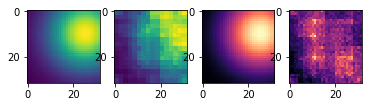

Epoch[10/50] Loss: 12442375.000 12442373.000 1.897


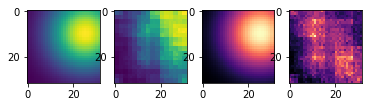

Epoch[11/50] Loss: 12434669.000 12434667.000 1.908


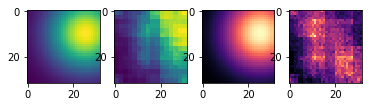

Epoch[12/50] Loss: 12452326.000 12452324.000 1.943


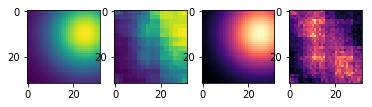

Epoch[13/50] Loss: 12398803.000 12398801.000 1.973


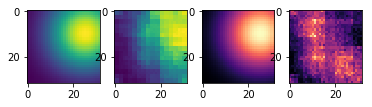

Epoch[14/50] Loss: 12376638.000 12376636.000 2.007


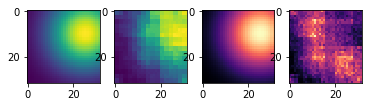

Epoch[15/50] Loss: 12346467.000 12346465.000 2.074


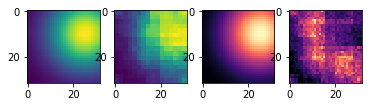

Epoch[16/50] Loss: 12396962.000 12396960.000 2.150


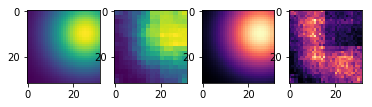

Epoch[17/50] Loss: 12355687.000 12355685.000 2.202


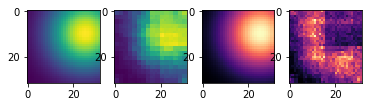

Epoch[18/50] Loss: 12362240.000 12362238.000 2.258


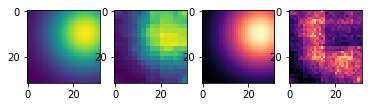

Epoch[19/50] Loss: 12389469.000 12389467.000 2.316


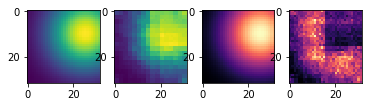

Epoch[20/50] Loss: 12351674.000 12351672.000 2.345


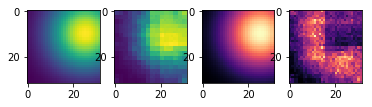

Epoch[21/50] Loss: 12359869.000 12359867.000 2.363


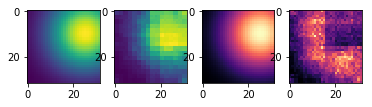

Epoch[22/50] Loss: 12345375.000 12345373.000 2.392


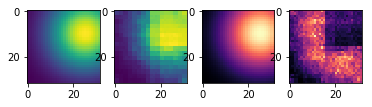

Epoch[23/50] Loss: 12344944.000 12344942.000 2.403


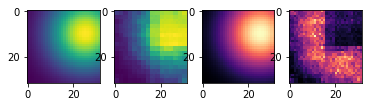

Epoch[24/50] Loss: 12322058.000 12322056.000 2.395


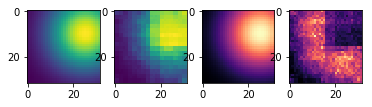

Epoch[25/50] Loss: 12298125.000 12298123.000 2.399


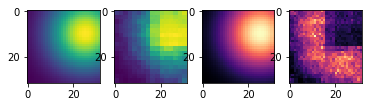

Epoch[26/50] Loss: 12300746.000 12300744.000 2.407


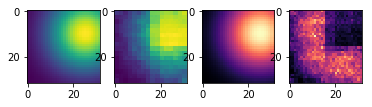

Epoch[27/50] Loss: 12269652.000 12269650.000 2.399


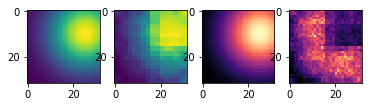

Epoch[28/50] Loss: 12265909.000 12265907.000 2.397


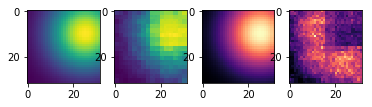

Epoch[29/50] Loss: 12258220.000 12258218.000 2.415


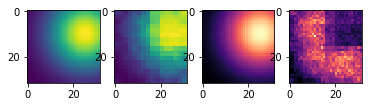

Epoch[30/50] Loss: 12262356.000 12262354.000 2.436


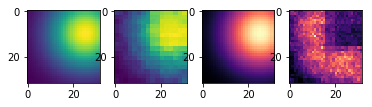

Epoch[31/50] Loss: 12252157.000 12252155.000 2.453


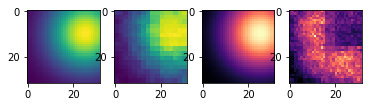

Epoch[32/50] Loss: 12250075.000 12250073.000 2.482


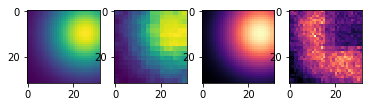

Epoch[33/50] Loss: 12251344.000 12251341.000 2.527


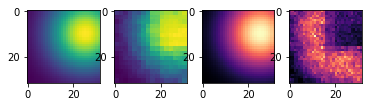

Epoch[34/50] Loss: 12253098.000 12253095.000 2.566


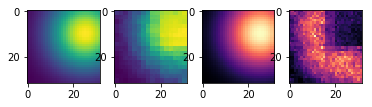

Epoch[35/50] Loss: 12255255.000 12255252.000 2.595


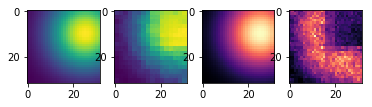

Epoch[36/50] Loss: 12256811.000 12256808.000 2.634


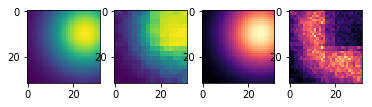

Epoch[37/50] Loss: 12265294.000 12265291.000 2.670


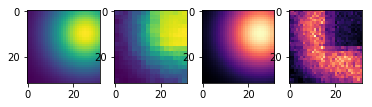

Epoch[38/50] Loss: 12252978.000 12252975.000 2.687


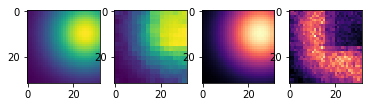

Epoch[39/50] Loss: 12252249.000 12252246.000 2.700


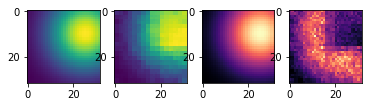

Epoch[40/50] Loss: 12250011.000 12250008.000 2.720


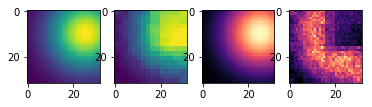

Epoch[41/50] Loss: 12242144.000 12242141.000 2.727


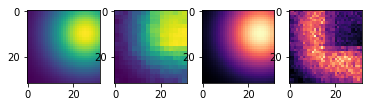

Epoch[42/50] Loss: 12235471.000 12235468.000 2.728


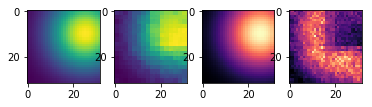

Epoch[43/50] Loss: 12231599.000 12231596.000 2.740


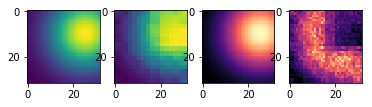

Epoch[44/50] Loss: 12232622.000 12232619.000 2.752


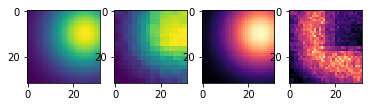

Epoch[45/50] Loss: 12226635.000 12226632.000 2.758


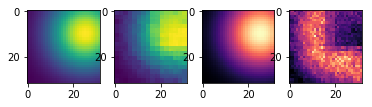

Epoch[46/50] Loss: 12223856.000 12223853.000 2.777


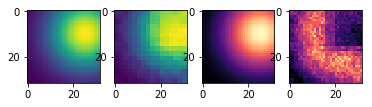

Epoch[47/50] Loss: 12227530.000 12227527.000 2.800


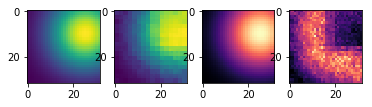

Epoch[48/50] Loss: 12224311.000 12224308.000 2.818


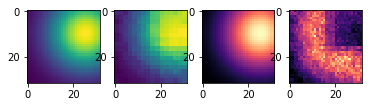

Epoch[49/50] Loss: 12223823.000 12223820.000 2.843


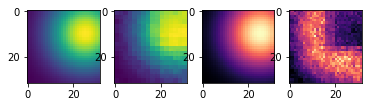

Epoch[50/50] Loss: 12223252.000 12223249.000 2.871


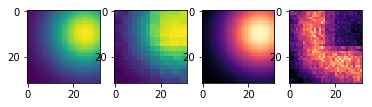

In [18]:
epochs = 100
for epoch in range(epochs):
    recon, mu, logvar = vae(data)
    loss, bce, kld = vae.loss(recon, data, mu, logvar)
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

    to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
                            epochs, loss.data[0], bce.data[0], kld.data[0])
    print(to_print)
    plt.subplot(1, 4, 1)
    plt.imshow(data[100].numpy().mean(axis=0))
    plt.subplot(1, 4, 2)
    plt.imshow(recon[100].detach().numpy().mean(axis=0))
    plt.subplot(1, 4, 3)
    plt.imshow(data[100].numpy().std(axis=0), cmap='magma')
    plt.subplot(1, 4, 4)
    plt.imshow(recon[100].detach().numpy().std(axis=0), cmap='magma')
    plt.show()

After 100 epochs of training, how well have we done?

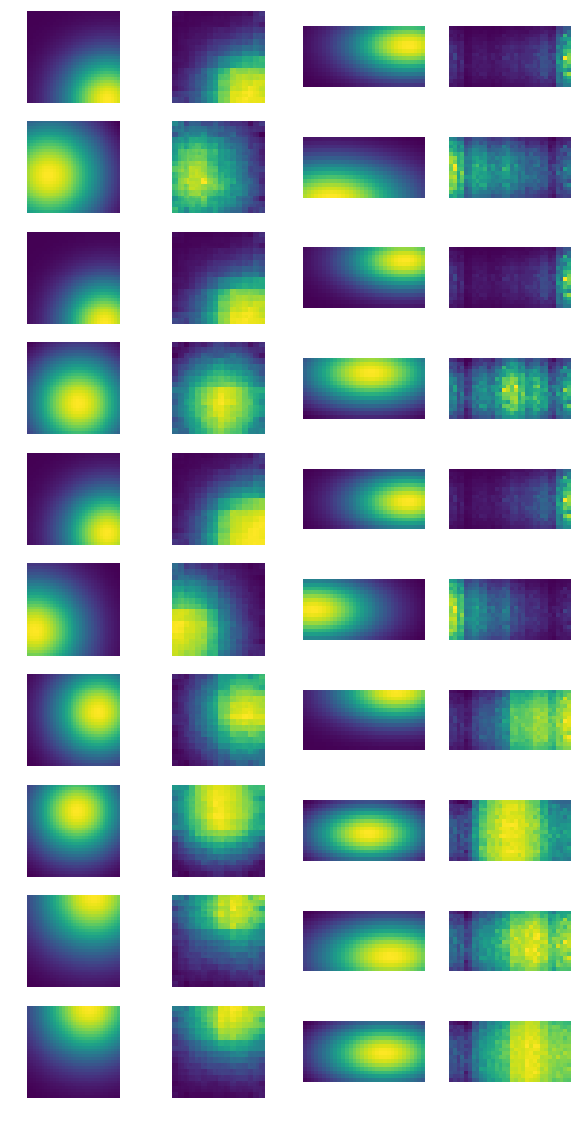

In [27]:
plt.figure(figsize=(10, 20))
for i in range(10):
    plt.subplot(10, 4, i * 4 + 1)
    plt.imshow(data[i].numpy().mean(axis=0))
    plt.axis('off')
    plt.subplot(10, 4, i * 4 + 2)
    plt.imshow(recon[i].detach().numpy().mean(axis=0))
    plt.axis('off')
    plt.subplot(10, 4, i * 4 + 3)
    plt.imshow(data[i].numpy()[:, 0, :])
    plt.axis('off')
    plt.subplot(10, 4, i * 4 + 4)
    plt.imshow(recon[i].detach().numpy()[:, 0, :])
    plt.axis('off')

## Jumping to 3D

How does this work if we now use a 3D convolution?

In [21]:
class UnFlatten3D(nn.Module):
    def __init__(self, size=2304):
        super().__init__()
        self.size = size
    def forward(self, input):
        return input.view(input.size(0), self.size, 1, 1, 1)

class VAE3D(nn.Module):
    def __init__(self, z_dim=32):
        super(VAE3D, self).__init__()
        h_dim = 9216
        self.encoder = nn.Sequential(
            nn.Conv3d(1, 32, kernel_size=(2, 4, 4), stride=2),
            nn.ReLU(),
            nn.Conv3d(32, 64, kernel_size=(2, 4, 4), stride=2),
            nn.ReLU(),
            Flatten(),
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten3D(h_dim),
            nn.ConvTranspose3d(h_dim, 64, kernel_size=(3, 5, 5), stride=2),
            nn.ReLU(),
            nn.ConvTranspose3d(64, 32, kernel_size=(3, 6, 6), stride=2),
            nn.ReLU(),
            nn.ConvTranspose3d(32, 1, kernel_size=(4, 6, 6), stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
        
    def representation(self, x):
        return self.bottleneck(self.encoder(x))[0]

    def forward(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        z = self.fc3(z)
        return self.decoder(z), mu, logvar

    @staticmethod
    def loss(recon_x, x, mu, logvar):
        BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
        KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

        return BCE + KLD, BCE, KLD

In [22]:
vae3d = VAE3D(z_dim=50).float()

In [23]:
data3d = data.reshape((2000, 1, 16, 32, 32))
vae3d.forward(data3d)[0].shape

torch.Size([2000, 1, 16, 32, 32])

In [24]:
optimiser3d = torch.optim.Adam(vae3d.parameters(), lr=1e-3)

/home/alg010/miniconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/100] Loss: 16777216.000 16777216.000 0.076


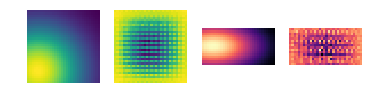

Epoch[2/100] Loss: 16782224.000 16782224.000 0.013


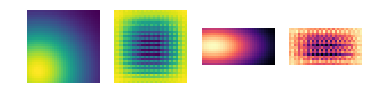

In [ ]:
epochs = 100
for epoch in tqdm(range(epochs)):
    recon, mu, logvar = vae3d(data3d)
    loss, bce, kld = vae3d.loss(recon, data3d, mu, logvar)
    optimiser3d.zero_grad()
    loss.backward()
    optimiser3d.step()

    to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
                            epochs, loss.item(), bce.item(), kld.item())
    print(to_print)
    plt.subplot(1, 4, 1)
    plt.imshow(data3d[100].numpy()[0].mean(axis=0))
    plt.axis('off')
    plt.subplot(1, 4, 2)
    plt.imshow(recon[100].detach().numpy()[0].mean(axis=0))
    plt.axis('off')
    plt.subplot(1, 4, 3)
    plt.imshow(data3d[100].numpy()[0, :, 0, :], cmap='magma')
    plt.axis('off')
    plt.subplot(1, 4, 4)
    plt.imshow(recon[100].detach().numpy()[0, :, 0, :], cmap='magma')
    plt.axis('off')
    plt.show()